In [3]:
!pip install transformers datasets torch scikit-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [44]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from torch.utils.data import DataLoader


In [45]:
df = pd.read_csv("/content/cleaned_twitter_sentiment_data.csv")  # Replace with actual dataset
df = df[["Sentiment", "Reviews"]]  # Keeping only required columns
df["Sentiment"] = df["Sentiment"].map({"positive": 2, "neutral": 1, "negative": 0})  # Convert to numerical labels
df.head(20)

,Sentiment,Reviews
0,0.0,coming border kill
1,0.0,im getting borderland kill
2,0.0,im coming borderland murder
3,0.0,im getting borderland murder
4,0.0,im getting borderland murder
5,2.0,spent hour making something fun dont know huge...
6,2.0,spent couple hour something fun dont know im h...
7,2.0,spent hour something fun dont know im huge bor...
8,2.0,spent hour making something fun dont know huge...
9,2.0,spent hour making something fun dont know huge...


Sentiment
0.0    22547
2.0    20826
1.0    18318
Name: count, dtype: int64


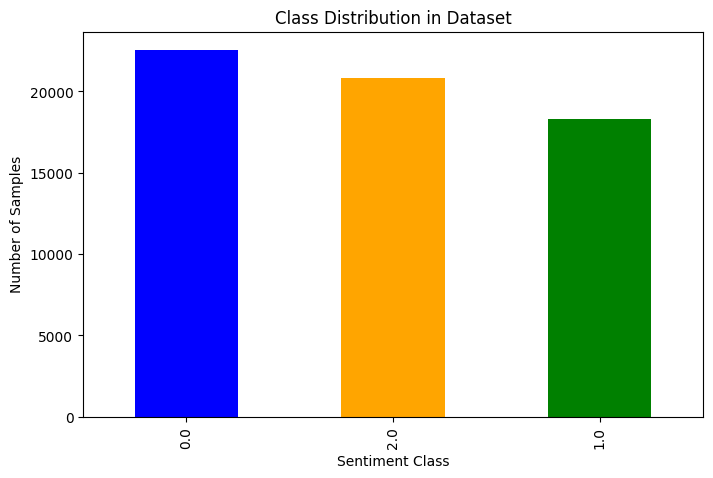

In [46]:
import matplotlib.pyplot as plt

# Count the number of instances per class
class_counts = df["Sentiment"].value_counts()

# Print class distribution
print(class_counts)

# Visualize the class distribution
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Dataset")
plt.show()




In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# ✅ Step 1: Handle missing values
df["Reviews"] = df["Reviews"].fillna("")  # Replace NaN with empty string
df["Reviews"] = df["Reviews"].astype(str)  # Ensure all reviews are strings

# ✅ Step 2: Encode labels
label_encoder = LabelEncoder()
df["Sentiment"] = label_encoder.fit_transform(df["Sentiment"])

# ✅ Step 3: Split dataset BEFORE applying SMOTE
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Reviews"], df["Sentiment"], test_size=0.2, random_state=42, stratify=df["Sentiment"]
)

# ✅ Step 4: Convert text to numerical format using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)  # Limit features to avoid overfitting
train_texts_tfidf = vectorizer.fit_transform(train_texts)

# ✅ Step 5: Apply SMOTE on the numerical feature vectors
smote = SMOTE(random_state=42)
train_texts_resampled, train_labels_resampled = smote.fit_resample(train_texts_tfidf, train_labels)

# ✅ Step 6: Convert resampled numerical vectors back to text using inverse TF-IDF
train_texts_resampled = vectorizer.inverse_transform(train_texts_resampled)

# Convert back to list format
train_texts_resampled = [" ".join(words) for words in train_texts_resampled]  # Join words into text format

# ✅ Step 7: Tokenization for BERT
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts_resampled, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=512)

# ✅ Now proceed with BERT training 🚀


In [48]:
import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler  # For mixed precision training

# ✅ Load Tokenizer & Model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# ✅ Move Model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ Sample Training Data (Replace with actual dataset)
train_texts = ["I love this product!", "I hate it!", "It’s okay, not great."]
train_labels = [2, 0, 1]  # Example: 2 = Positive, 0 = Negative, 1 = Neutral

# ✅ Convert Text to Tokenized Inputs
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

# ✅ Convert Labels to Tensors
train_labels = torch.tensor(train_labels)

# ✅ Create Dataset & DataLoader
train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Adjust batch size if needed

# ✅ Define Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)

# ✅ Mixed Precision Training for Speedup
scaler = GradScaler()

# ✅ Training Loop with Time Estimation & Gradient Clipping
EPOCHS = 3
model.train()

start_time = time.time()  # Start timer

for epoch in range(EPOCHS):
    epoch_start_time = time.time()  # Time for each epoch
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()  # Reset gradients

        with autocast():  # Enable Mixed Precision
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

        # Backward pass with Mixed Precision
        scaler.scale(loss).backward()

        # ✅ Gradient Clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        scaler.step(optimizer)
        scaler.update()

    scheduler.step()

    epoch_time = time.time() - epoch_start_time  # Time taken for this epoch
    remaining_time = (EPOCHS - (epoch + 1)) * epoch_time  # Estimate remaining time
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f} - Time: {epoch_time:.2f}s - Estimated Remaining Time: {remaining_time:.2f}s")

total_time = time.time() - start_time
print(f"\n✅ Training Completed in {total_time:.2f}s ({total_time/60:.2f} minutes)")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-48-8c672ae0e165>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-48-8c672ae0e165>:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable Mixed Precision


Epoch 1 - Loss: 1.2124 - Time: 0.20s - Estimated Remaining Time: 0.40s
Epoch 2 - Loss: 1.1760 - Time: 0.12s - Estimated Remaining Time: 0.12s
Epoch 3 - Loss: 1.1941 - Time: 0.13s - Estimated Remaining Time: 0.00s

✅ Training Completed in 0.46s (0.01 minutes)


In [49]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, classification_report

# ✅ Load Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Sample Test Data (Replace with actual dataset)
test_texts = ["This movie was amazing!", "Worst product ever!", "It was okay, nothing special."]
true_labels = [2, 0, 1]  # 2 = Positive, 0 = Negative, 1 = Neutral

# ✅ Convert Text to Tokenized Inputs
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

# ✅ Convert Labels to Tensors
true_labels_tensor = torch.tensor(true_labels)

# ✅ Create Dataset & DataLoader
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], true_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# ✅ Move Model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# ✅ Perform Inference (Disable Gradients for Efficiency)
predictions = []
true_labels_list = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward Pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Extract predictions

        # Convert logits to predicted labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels_list.extend(labels.cpu().numpy())

# ✅ Compute Accuracy & Classification Report
accuracy = accuracy_score(true_labels_list, predictions)
report = classification_report(true_labels_list, predictions, target_names=["Negative", "Neutral", "Positive"])

print(f"\n✅ Model Accuracy on Test Data: {accuracy:.4f}")
print("\n🔍 Classification Report:\n", report)



✅ Model Accuracy on Test Data: 0.6667

🔍 Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         1
     Neutral       0.50      1.00      0.67         1
    Positive       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, classification_report

# ✅ Load Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Define Test Prompts
test_texts = [
    "I never expected things to turn out this way.",
    "That was definitely something different.",
    "I guess this is what I was waiting for.",
    "Well, that’s one way to look at it.",
    "I can’t say I’m surprised."
]

# ✅ Convert Text to Tokenized Inputs
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

# ✅ Create Dataset & DataLoader (No labels since we're just testing predictions)
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ✅ Move Model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# ✅ Perform Inference (Disable Gradients for Efficiency)
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = [b.to(device) for b in batch]

        # Forward Pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Extract predictions

        # Convert logits to predicted labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)

# ✅ Print Model Predictions
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

print("\n Model Predictions:")
for text, pred in zip(test_texts, predictions):
    print(f" Text: {text}   Sentiment: {sentiment_labels[pred]}\n")



 Model Predictions:
 Text: I never expected things to turn out this way.   Sentiment: Negative

 Text: That was definitely something different.   Sentiment: Neutral

 Text: I guess this is what I was waiting for.   Sentiment: Neutral

 Text: Well, that’s one way to look at it.   Sentiment: Neutral

 Text: I can’t say I’m surprised.   Sentiment: Neutral

